# Machine Learning Project

__Pia CHANCEREL - Raphael LASRY - Maxime POLI__

Based on the article :

_A Continuation Method for Semi-Supervised SVMs_

Olivier Chapelle $\hspace{3.9cm}$ olivier.chapelle@tuebingen.mpg.de

Mingmin Chi $\hspace{4.5cm}$ mingmin.chi@tuebingen.mpg.de

Alexander Zien $\hspace{4.1cm}$ alexander.zien@tuebingen.mpg.de


Max Planck Institute for Biological Cybernetics, Tübingen, Germany

https://dl.acm.org/doi/pdf/10.1145/1143844.1143868?download=true

In [91]:
import numpy as np
import scipy as sc
import pandas as pd
from tqdm import tqdm
import time as time

# Data

20newsgroup dataset: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

Dataset of an old forum. We will only focus on messages related to windows and mac. The goal is to predict the subject of the message (windows or mac) thanks to a $S^3VM$ method.

In [92]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import PolynomialFeatures

In [93]:
data = pd.read_csv('data.csv')
data['date_int'] = pd.to_datetime(data['date']).dt.strftime("%Y%m%d").astype(int)
city = pd.get_dummies(pd.Categorical(data['city']), prefix='city')
X_housedata = np.concatenate([data[['date_int', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']].to_numpy(), city.to_numpy()], axis=1)
Y_housedata = data['price'].to_numpy()

r = np.random.permutation(len(X_housedata))
X_train = X_housedata[r[0:3500], :]
Y_train = Y_housedata[r[0:3500]]
X_val = X_housedata[r[3500:4000], :]
Y_val = Y_housedata[r[3500:4000]]
X_test = X_housedata[r[4000:], :]
Y_test = Y_housedata[r[4000:]]

X_train = (X_train - np.mean(X_train, axis = 0)) / (np.std(X_train, axis = 0) + 10 ** (-15))
X_val = (X_val - np.mean(X_val, axis = 0)) / (np.std(X_val, axis = 0) + 10 ** (-15))
X_test = (X_test - np.mean(X_test, axis = 0)) / (np.std(X_test, axis = 0) + 10 ** (-15))

Y_train = 2 * np.array(np.array(Y_train) - np.median(Y_train) > 0).astype(int) - 1
Y_val = 2 * np.array(np.array(Y_val) - np.median(Y_val) > 0).astype(int) - 1
Y_test = 2 * np.array(np.array(Y_test) - np.median(Y_test) > 0).astype(int) - 1

In [94]:
# print(newsgroups_train.DESCR) # Documentation of how to use the dataset

In [95]:
cat = ['comp.sys.mac.hardware', 'comp.os.ms-windows.misc']
# cat = ['sci.crypt', 'sci.electronics']
newsgroups_train = fetch_20newsgroups(subset = 'train', categories = cat) 
newsgroups_test = fetch_20newsgroups(subset = 'test', categories = cat) 

In [96]:
print('training set')
print('posts', newsgroups_train.filenames.shape) # Text, content of the messages
print('class', newsgroups_train.target.shape) # In which categories the message should be classified
print('test set')
print('posts', newsgroups_test.filenames.shape)
print('class', newsgroups_test.target.shape)

training set
posts (1169,)
class (1169,)
test set
posts (779,)
class (779,)


In [97]:
# Converting text to vectors
vectorizer = TfidfVectorizer(encoding='latin1')
# Pas sûr de ma solution mais ça a l'air d'être ça
vectorizer.fit(newsgroups_train.data+newsgroups_test.data) # From a text message to a sparse matrix
vectors_train = vectorizer.transform(newsgroups_train.data)
vectors_test = vectorizer.transform(newsgroups_test.data)
print(vectors_train.shape)
print(vectors_test.shape)

(1169, 64711)
(779, 64711)


In [98]:
# Nombre moyen de features non nulles
vectors_test.nnz/float(vectors_test.shape[0])

134.997432605905

In [99]:
print(vectors_train) # Sparse matrix. The first index is the index of the message and the second ones are the indexes whithin this matrix where the value isn't a 0.

  (0, 64049)	0.48698547371009104
  (0, 63176)	0.08657387052179862
  (0, 57623)	0.029946272245423237
  (0, 57374)	0.14037101449771663
  (0, 56007)	0.0379672998581152
  (0, 55632)	0.053424020420574446
  (0, 55628)	0.055301137935004706
  (0, 55616)	0.12174636842752276
  (0, 54250)	0.01693561543176528
  (0, 52541)	0.06864484419802228
  (0, 47088)	0.046707759073707104
  (0, 45489)	0.017492089885747925
  (0, 44970)	0.04061802614096353
  (0, 42725)	0.03137224370687498
  (0, 40041)	0.0350193637580241
  (0, 39476)	0.12174636842752276
  (0, 37639)	0.09287541032933726
  (0, 37615)	0.05948595403656421
  (0, 37283)	0.016987832170248945
  (0, 35951)	0.03630556668468965
  (0, 33448)	0.04507733059640645
  (0, 33364)	0.04324091422736177
  (0, 32785)	0.0215518454785867
  (0, 32419)	0.02923096397332353
  (0, 30806)	0.04706431151540918
  :	:
  (1168, 27572)	0.08697259923806679
  (1168, 27081)	0.05745095491042798
  (1168, 24695)	0.11124046544647209
  (1168, 24671)	0.2385789602475931
  (1168, 24613)	0.31736

# S3VM

In [ ]:
X = np.ones((3, 4))
Y = np.arange(3)
print(np.multiply(X.T, Y).T)
(X.T * Y).T

In [151]:
class S3VMClassifier():
    """
        S3VM class as defined in the article.
    """
    def __init__(self, C=1.0, C_=1.0, lr=0.01, s=3):
        self.C = C
        self.C_ = C_
        self.lr = lr
        self.s = s
        self.X = None
        self.Y = None
        self.X_ = None
        self.w = None
        self.b = None
        
    def compute_gamma(self, epochs):
        """
            Compute the list of values of gamma (defined at the §3.2).
        """
        m, d = self.X_.shape
#         matrix = sc.sparse.lil_matrix((d, d))
        matrix = np.zeros((d, d))
        for i in range(m):
#             matrix += self.X_[i].T@self.X_[i] / sc.sparse.linalg.norm(self.X_[i]) ** 3
            matrix += self.X_[i].T@self.X_[i] / np.linalg.norm(self.X_[i]) ** 3

        lamb_max = np.linalg.eigh(matrix)[0][- 1]
        gamma_0 = (self.C_ * lamb_max) ** (2 / 3) / (2 * self.s) ** (1 / 3)
#         gamma_end = 1 / (epochs * 2 * self.s * sc.sparse.linalg.norm(self.X_, axis=1).max() ** 2)
        gamma_end = 1 / (epochs * 2 * self.s * np.linalg.norm(self.X_, axis=1).max() ** 2)
        gamma_list = [(gamma_end / gamma_0) ** (i / epochs) * gamma_0 for i in range(epochs)]
        return gamma_list
    
    def loss(self, gamma):
        """
            Compute the convolved loss (defined at the end of the §3.1).
        """
        d = self.X.shape[1]
        a = 1 + 2 * gamma * self.s * np.linalg.norm(self.X_, axis = 1) ** 2
        e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / np.linalg.norm(self.X, axis = 1)
        L_labelled = self.C * np.sum(gamma * np.linalg.norm(self.X, axis = 1) / np.sqrt(2) 
                                     * (np.exp(- e ** 2) / np.sqrt(np.pi) - e * sc.special.erfc(e)))
        L_unlabelled = self.C_ * np.sum(1 / np.sqrt(a) * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a))
        return np.dot(self.w, self.w) / 2 + gamma * d / 2 + L_labelled + L_unlabelled
    
    def gradient_loss(self, gamma, labelled):
        """
            Compute the gradient of the loss (defined at the end of the §3.1).
        """
        a = 1 + 2 * gamma * self.s * np.linalg.norm(self.X_, axis = 1) ** 2
        e = (self.Y * (self.X.dot(self.w) + self.b) - 1) / np.sqrt(2 * gamma) / np.linalg.norm(self.X, axis = 1)
        if labelled:
            dL_labelled = self.C / 2 * np.sum(np.multiply(self.X.T, sc.special.erfc(e) * self.Y).T, axis=0)
            return self.w - dL_labelled
        else:
            dL_unlabelled = self.C_ * np.sum(np.multiply(self.X_.T, 2 * self.s * (self.X_.dot(self.w) + self.b) / a ** (3 / 2)
                                         * np.exp(- self.s * (self.X_.dot(self.w) + self.b) ** 2 / a)), axis=1)
            return self.w - dL_unlabelled
    
    def minimize(self, gamma, epochs):
        """
            Optimise the parameters.
        """
        n, d = self.X.shape
        m = self.X_.shape[0]
        indexes = np.arange(n + m) - m # positive indexes --> labeled & negative indexes --> unlabeled
        gw = np.zeros((n + m, d)) # vector of most recent gradient in w
        dw = np.zeros(d) # sum of gw
        for ep in range(epochs):
            np.random.shuffle(indexes)
            for k in range(n + m):
                i = indexes[k]
                labelled = (i >= 0) # labelled or unlabelled
                if i < 0 : # if it's the index of an unlabelled data
                    i = - i + n - 1 # its index is in gw
                dw -= gw[i]
                gw[i] = self.gradient_loss(gamma, labelled)
                dw += gw[i]
                self.w -= self.lr / min((k + 1) + ep * (n + m), n + m) * dw
    
    def fit(self, X, Y, X_, epochs=3, iter_gamma=5, w=None, b=None): # epochs pour la minimisation, iter_gamma pour le nombre de gamma
        """
            Train the model on X_labelled, Y_labelled, X_unlabelled datas.
        """
        self.X = X
        self.Y = Y
        
        # Centering unlablled data
#         values = X_[X_.nonzero()]
#         values -= sc.sparse.spmatrix.mean(values, axis = 1)
#         self.X_ = values
        self.X_ = X_
        
        gamma_list = self.compute_gamma(iter_gamma)
        # warm start
        if (w is None) and (b is None) :
            _, d = self.X.shape
            self.w = np.zeros(d)
            self.b = np.mean(Y)
        # continuation method
        for gamma in tqdm(gamma_list):
            self.minimize(gamma, epochs)

        self.b = self.w[0]
        self.w = self.w[1:]
    def predict(self, X):
        """
            Predict the value of Y (0 or 1).
        """
        return 2*(self.w.T.dot(X.T) + self.b >= 0)-1
    
    def accuracy(self, X, Y):
        """
            Evaluate the accuracy of the prediction.
        """
        return (self.predict(X) == Y).mean()

In [101]:
def make_meshgrid(points, h=0.2):
    x_min, x_max = points[:,0].min() - 1, points[:,0].max() + 1
    y_min, y_max = points[:,1].min() - 1, points[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, model, X, Y, **params):
    xx, yy = make_meshgrid(X)
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, **params)
    ax.scatter(X[:, 0], X[:, 1], c=Y, s=20, cmap=plt.cm.Spectral)
    ax.set_axis_off()

In [102]:
#Ma SAGC juste pour débugger

class Model():
    def __init__(self):
        self.stand = False
        self.norm = False
        self.eigen_vecs = None

    def standardize(self, X):
        return (X - np.mean(X, 0))/(np.std(X,0)+10**(-11))

    def normalize(self, X):
        return X/np.linalg.norm(X, axis=1, keepdims=True)
        
    def orthogonalize(self, X, nb_col):
        assert(np.mean(X)!=0)
        K = np.dot(X.T, X) / len(X)
        _, eigen_vecs = np.linalg.eigh(K)
        self.eigen_vecs = eigen_vecs[:,-nb_col:]
    

class SAGClassifier(Model):
    def __init__(self, lambada=1e-3, eta=1e-2):
        super().__init__()
        self.lambada = lambada
        self.eta = eta
        self.w = None
        self.loss = None # Liste conservant la loss cumulée à chaque époque

        
    def fit(self, X, Y, epochs=5, nb_iter=None, stand=False, norm=False, nb_col=None):
        self.stand = stand
        self.norm = norm
        self.loss = []
        # Traitement des données
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=1)
        if nb_col is None:
            self.eigen_vecs = None
        if self.norm:
            X = self.normalize(X)
        if self.stand:
            X = self.standardize(X)
            if nb_col is not None:
                self.orthogonalize(X, nb_col)
                X = np.dot(X, self.eigen_vecs)
        
        # Implémentation de la SAG
        X = np.hstack((np.ones((X.shape[0], 1)), X)) # Ajoute colonne de 1
        n, m = X.shape
        self.w = np.zeros(m)
        d = np.zeros(m)
        if nb_iter is not None:
            n = min(nb_iter, n)
        gradient = np.zeros((n, m))
        for k in range(epochs):
            r = np.random.permutation(n)
            X, Y, gradient = X[r, :], Y[r], gradient[r, :]
            current_loss = 0
            for i in range(n):
                d -= gradient[i]
                hinge_loss = max(0,1-Y[i]*np.dot(X[i], self.w))
                current_loss += hinge_loss
                gradient[i] = -Y[i]*X[i] if hinge_loss > 0 else np.zeros(m)
                d += gradient[i]
                # L'article n'étant pas clair sur le "number of unique values sampled so far" 
                # et la gestion des époques, je l'ai interprété comme ci-dessous
                count = i+1 if k == 0 else n
                self.w[1:] = (1 - self.eta*self.lambada) * self.w[1:] - self.eta * d[1:]/count
                self.w[0] = self.w[0] - self.eta*d[0]/count
            current_loss = 0.5*self.lambada*np.dot(self.w[1:], self.w[1:]) + current_loss/n
            self.loss.append(current_loss)
    
    
    def predict(self, X):
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=1)
        if self.norm:
            X = self.standardize(X)
        if self.stand:
            X = self.standardize(X)
            if self.eigen_vecs is not None:
                X = np.dot(X, self.eigen_vecs)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return 2*(np.dot(X,self.w) >= 0) - 1


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:28<00:00,  5.72s/it]

1.0


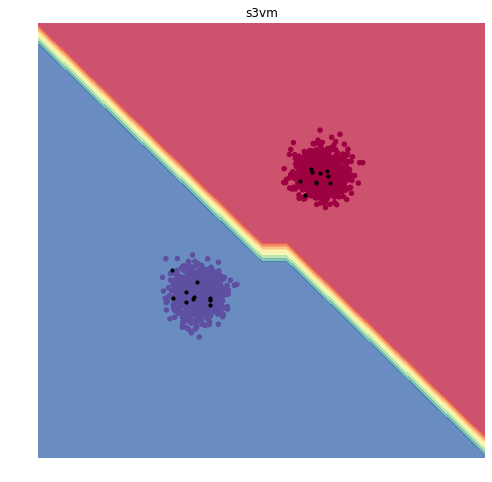

In [156]:
import matplotlib.pyplot as plt

n = 1000
m = 100
sigma = 0.01

x = np.concatenate(
    (np.random.multivariate_normal([0,0], [[sigma, 0], [0, sigma]], n),
     np.random.multivariate_normal([1,1], [[sigma, 0], [0, sigma]], n))
)

y = np.concatenate((np.ones(n), -np.ones(n)))

x_ = np.concatenate(
    (np.random.multivariate_normal([0,0], [[sigma, 0], [0, sigma]], m),
     np.random.multivariate_normal([1,1], [[sigma, 0], [0, sigma]], m))
)

mat = PolynomialFeatures(1)
x1 = mat.fit_transform(x)
x1_ = mat.fit_transform(x_)
    
# s3vm = SAGClassifier()
# s3vm.fit(x, y)

s3vm = S3VMClassifier()
s3vm.fit(x1, y, x1_, epochs = 5)
print(s3vm.accuracy(x, y))

fig, ax = plt.subplots(figsize=(8,8))
plot_contours(ax, s3vm, x, y, alpha=0.8)
ax.scatter(x[:, 0], x[:, 1], c=y, s=10, cmap=plt.cm.Spectral)
ax.scatter(x_[:, 0], x_[:, 1], c='black', s=10)
ax.set_title("s3vm")
# ax.set_title("sagc")

plt.show()

In [155]:
print(s3vm.w)
print(s3vm.b)

[-2.34317294 -2.44968455]
2.2836485051591966


In [124]:
s3vm = S3VMClassifier()

# s3vm.fit(vectors_train[:int(0.75 * vectors_train.shape[0]), :], 
#          newsgroups_train.target[:int(0.75 * vectors_train.shape[0])], 
#          vectors_train[int(0.75 * vectors_train.shape[0]):, :])
# print(s3vm.accuracy(vectors_test, newsgroups_test))

proportion = 0.1
nb_labelled = int(proportion * X_train.shape[0])
s3vm.fit(X_train[:nb_labelled, :], Y_train[:nb_labelled], X_train[nb_labelled:, :])
print(s3vm.accuracy(X_test, Y_test))

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [04:17<00:00, 51.49s/it]


0.7283333333333334


In [113]:
# Y = s3vm.predict(X_test)
# print(*zip(Y.astype(int), Y_test))

In [125]:
print(s3vm.w)
print(s3vm.b)

[ 1.82477928e-02  7.45929693e-02 -3.43563446e-01  1.39543510e-02
  5.49129414e-01  1.30331649e-01 -3.00069071e-01  3.34406052e+00
  2.94520158e-01 -9.62572261e-02  2.03440800e-01  1.83762208e-01
  9.42948731e-02 -5.02638022e-01 -2.19541716e-01  0.00000000e+00
  1.40679427e+00 -5.70364716e-01 -1.51757959e+00 -2.38883242e+00
  7.66783321e-01  1.09372973e+00 -2.71563895e-01 -1.06466110e-01
  4.34828745e-04 -3.58914942e-01 -2.12141370e+00 -3.19649795e+00
  8.17514241e-02  6.48932303e-01  8.22723218e-01 -1.04158524e+00
 -2.65377059e-01 -2.25190467e+00 -1.64341351e+00  1.91835343e+00
  1.52391505e+00 -1.16170520e-01  7.58726880e-01  1.24086911e+00
 -1.50774995e+00 -1.04405719e-02 -3.28646810e-01 -9.53089237e-01
  3.07568956e+00 -3.99090402e-01  1.19890860e+00 -3.69959737e-01
 -2.64890266e-01 -4.41787372e-01 -4.38023380e-02  1.28441745e+00
  2.21510223e-01 -1.25000792e-01  1.35507573e+00  1.45899297e+00
  4.64652951e-01]
-0.018247792817331406
